# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [5]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [6]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [7]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")  # Ваги шару
        self.b = tf.Variable(tf.zeros([out_features]), name="b")  # Зсув шару

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return y


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Первый слой, состоящий из 128 нейронов
        self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

        # Второй слой, состоящий из 256 нейронов
        self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

        # Выходной слой
        self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

    def __call__(self, x):
        x = self.layer_1(x)
        x = tf.nn.sigmoid(x)
        x = self.layer_2(x)
        x = tf.nn.sigmoid(x)
        x = self.layer_3(x)
        x = tf.nn.softmax(x)
        return x


In [8]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    predictions = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.cast(tf.equal(predictions, tf.cast(y_true, tf.int64)), dtype=tf.float32)
    accuracy = tf.reduce_mean(correct_predictions)
    return accuracy



In [9]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    params = nn.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, params)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, params))

    return loss


In [10]:
# Тренировка сети
from tqdm import tqdm
loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in tqdm(enumerate(train_data.take(2000))):
  # Обновляем веса нейронной сети
    loss_tr = train(neural_net, batch_x, batch_y)

    # Виведення результатів на екран при заданих кроках
    if step % display_step == 0:
        pred_tr = neural_net(batch_x)  # Отримання передбачень на тренувальних даних
        acc_tr = accuracy(pred_tr, batch_y)  # Обчислення точності на тренувальних даних
        loss_history.append(loss_tr)  # Додавання втрати до історії на тренувальному наборі
        accuracy_history.append(acc_tr)  # Додавання точності до історії на тренувальному наборі

        print(f"Step {step}, Loss: {loss_tr}, Accuracy: {acc_tr}")

0it [00:00, ?it/s]WARNING:tensorflow:5 out of the last 5 calls to <function _BaseOptimizer._update_step_xla at 0x7c8410339ab0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1it [00:05,  5.45s/it]

Step 0, Loss: 2848.7587890625, Accuracy: 0.125


101it [00:31,  4.17it/s]

Step 100, Loss: 360.4720458984375, Accuracy: 0.6875


201it [00:56,  4.25it/s]

Step 200, Loss: 287.939208984375, Accuracy: 0.7421875


301it [01:24,  4.25it/s]

Step 300, Loss: 214.4969940185547, Accuracy: 0.80859375


401it [01:49,  4.13it/s]

Step 400, Loss: 183.52960205078125, Accuracy: 0.82421875


501it [02:21,  3.27it/s]

Step 500, Loss: 182.85665893554688, Accuracy: 0.84375


601it [02:46,  2.94it/s]

Step 600, Loss: 134.41714477539062, Accuracy: 0.8515625


701it [03:11,  3.05it/s]

Step 700, Loss: 91.11660766601562, Accuracy: 0.90234375


801it [03:36,  3.49it/s]

Step 800, Loss: 97.45266723632812, Accuracy: 0.91796875


901it [04:03,  3.12it/s]

Step 900, Loss: 104.222900390625, Accuracy: 0.90234375


1001it [04:28,  3.73it/s]

Step 1000, Loss: 125.80766296386719, Accuracy: 0.890625


1101it [04:54,  4.23it/s]

Step 1100, Loss: 120.7868423461914, Accuracy: 0.89453125


1201it [05:19,  4.15it/s]

Step 1200, Loss: 97.99949645996094, Accuracy: 0.90625


1301it [05:45,  4.17it/s]

Step 1300, Loss: 105.3134536743164, Accuracy: 0.8984375


1401it [06:10,  4.28it/s]

Step 1400, Loss: 70.85938262939453, Accuracy: 0.9296875


1501it [06:36,  4.22it/s]

Step 1500, Loss: 87.97650146484375, Accuracy: 0.9140625


1601it [07:01,  4.20it/s]

Step 1600, Loss: 110.24946594238281, Accuracy: 0.890625


1701it [07:27,  4.23it/s]

Step 1700, Loss: 79.43116760253906, Accuracy: 0.90625


1801it [07:53,  4.14it/s]

Step 1800, Loss: 87.82621765136719, Accuracy: 0.90625


1901it [08:19,  4.09it/s]

Step 1900, Loss: 95.74842071533203, Accuracy: 0.9140625


2000it [11:57,  2.79it/s]


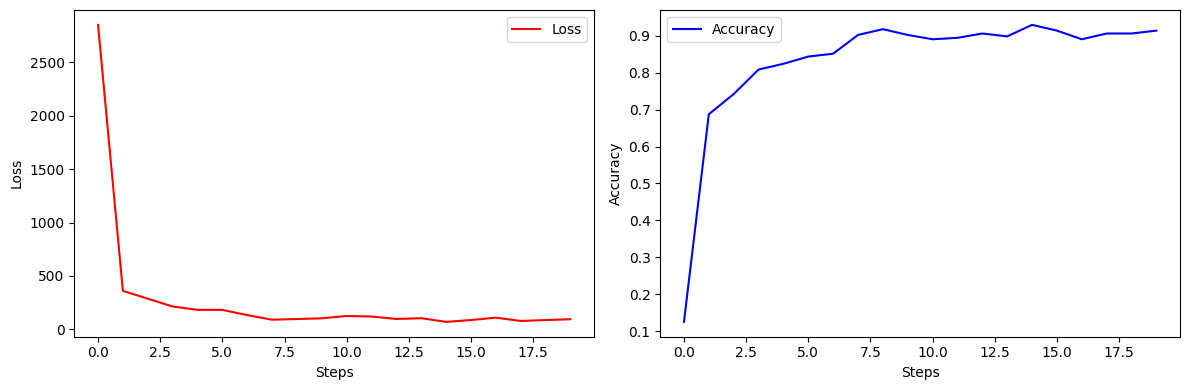

In [15]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

import matplotlib.pyplot as plt

# Графік зміни втрат
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss', color='red')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Графік зміни точності
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy', color='blue')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
# Вычислите точность обученной нейросети
from sklearn.metrics import accuracy_score, precision_score, recall_score

pred_test = neural_net(x_test)
predicted_labels = tf.argmax(pred_test, axis=1).numpy()

accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels, average='macro')
recall = recall_score(y_test, predicted_labels, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 0.8908
Precision: 0.889730817031543
Recall: 0.8895476562689947


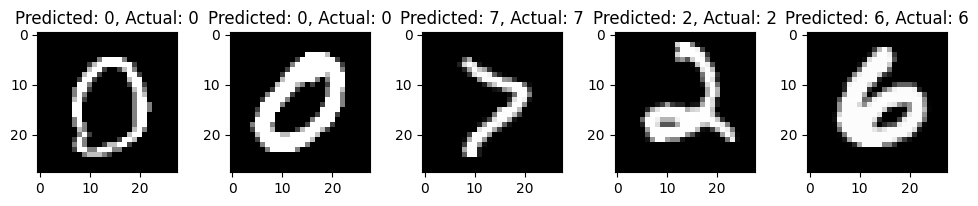

False 0 / 5.
Accuracy: 100.00%


In [31]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?
import random

rand_id = random.sample(range(len(x_test)), 10)
test_images = x_test[rand_id]
test_labels = y_test[rand_id]

predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.title(f'Predicted: {predicted_labels[i]}, Actual: {test_labels[i]}')
plt.show()

false_pred= np.sum(predicted_labels != test_labels)
accuracy = 1.0 - (false_pred / 10.0)

print(f"False {false_pred} / 5.")
print(f"Accuracy: {accuracy * 100:.2f}%")

